# Video Game Sales Data Analysis

Author: **Marcin Sikorski**<br/>
Date: July, 2021

This analysis aims to practice data wrangling and data visualizing with Python libraries. I also used <code>sklearn</code> to perform a simple prediction using machine learning. The report was written in Jupyter Notebook in Python 3.

#### Report content:
1. Dataset Description
2. Preparing and Cleaning Data
3. Visualizing Data
4. Predicting Global Sales Based on Europe Sales with Linear Regression
5. Conclusions


### 1. Dataset Description

This dataset contains a list of video games with sales greater than 100,000 copies. It was generated by a web scrape of [vgchartz][1]. Data were extracted with <code>BeautifulSoup</code> using Python.
It includes: name, platform, year, genre, publisher, and sales per region. The dataset was downloaded from [Kaggle][2] [Accessed 20th July 2021]. Sales are given in millions.

[1]: https://www.vgchartz.com 'vgchartz'
[2]: https://www.kaggle.com/gregorut/videogamesales 'Kaggle'

In [1]:
# necessary modules
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load data from csv file
df = pd.read_csv('vgsales.csv')

In [3]:
# show header and rows
df.head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


### 2. Preparing and Cleaning Data

In [4]:
# basic descriptive statistics about dataframe
print(df.shape)
df.describe().T

(16598, 11)


,count,mean,std,min,25%,50%,75%,max
Rank,16598.0,8300.605254,4791.853933,1.00,4151.25,8300.50,12449.75,16600.00
Year,16327.0,2006.406443,5.828981,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16598.0,0.264667,0.816683,0.00,0.00,0.08,0.24,41.49
EU_Sales,16598.0,0.146652,0.505351,0.00,0.00,0.02,0.11,29.02
JP_Sales,16598.0,0.077782,0.309291,0.00,0.00,0.00,0.04,10.22
Other_Sales,16598.0,0.048063,0.188588,0.00,0.00,0.01,0.04,10.57
Global_Sales,16598.0,0.537441,1.555028,0.01,0.06,0.17,0.47,82.74


Comparing dataframe shape with its basic statistics, we can spot that not all columns have complete data - <code>Year</code>. We will submit missing values. This action will not affect our further analysis.

In [5]:
# sum NaN values in columns
df.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [6]:
# drop rows with NaN in columns 'Publisher' and 'Year'
df = df.dropna(how='any', subset=['Publisher', 'Year'], axis=0)
# reset index
df = df.reset_index(drop=True)
# sum NaN values in columns
df.isna().sum()

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

The <code>Year</code> column has digits after its decimal separator. Let's convert this column from float to it's proper data type - integer.

In [7]:
# convert data type
df['Year'] = df['Year'].astype(int)
df['Year'].dtype

dtype('int32')

In [8]:
# basic summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16291 entries, 0 to 16290
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16291 non-null  int64  
 1   Name          16291 non-null  object 
 2   Platform      16291 non-null  object 
 3   Year          16291 non-null  int32  
 4   Genre         16291 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16291 non-null  float64
 7   EU_Sales      16291 non-null  float64
 8   JP_Sales      16291 non-null  float64
 9   Other_Sales   16291 non-null  float64
 10  Global_Sales  16291 non-null  float64
dtypes: float64(5), int32(1), int64(1), object(4)
memory usage: 1.1+ MB


Now we will search for duplicates.

In [9]:
# find duplicate rows
df.duplicated().any()

False

Considering that the data is a panel data including time, we will check the data distribution of each year to find outliers in dataframe.

In [10]:
df.groupby('Year').count()

,Rank,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Year,,,,,,,,,,
1980,9,9,9,9,9,9,9,9,9,9
1981,46,46,46,46,46,46,46,46,46,46
1982,36,36,36,36,36,36,36,36,36,36
1983,17,17,17,17,17,17,17,17,17,17
1984,14,14,14,14,14,14,14,14,14,14
1985,14,14,14,14,14,14,14,14,14,14
1986,21,21,21,21,21,21,21,21,21,21
1987,16,16,16,16,16,16,16,16,16,16
1988,15,15,15,15,15,15,15,15,15,15


The amount of data in 2017 and 2020 seems to be incomplete and the years between the two are not continuous. There is missing data for 2018 and 2019 so we will delete these rows.

In [11]:
# drop rows for 'Year' higher then 2016
df = df.drop(df[df['Year'] > 2016].index)

Our data is ready for visualizaing!

### 3. Visualizing Data

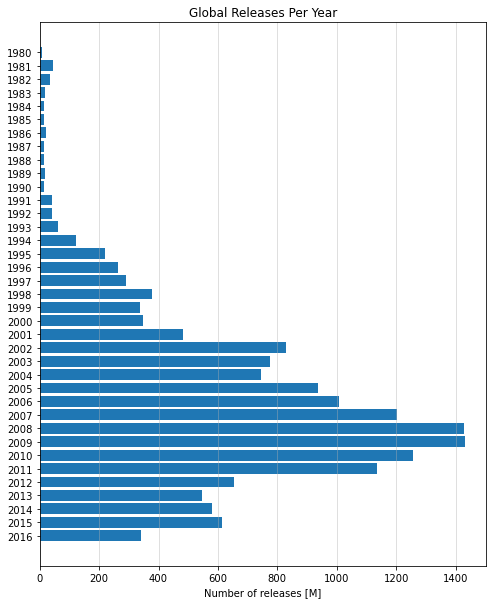

In [12]:
# plot_1 - global releases per year
x = df.groupby('Year').count()['Global_Sales']
y = x.index

plt.figure(figsize=(8,10))
plt.barh(y, x, align='center', tick_label=y)
plt.grid(axis='x', alpha=.5)
plt.gca().invert_yaxis()
plt.title('Global Releases Per Year')
plt.xlabel('Number of releases [M]')

plt.show()

In [13]:
# top 10 best selling video game
df.sort_values(by=['Global_Sales'], ascending=False).head(10)[['Name', 'Global_Sales']]

,Name,Global_Sales
0,Wii Sports,82.74
1,Super Mario Bros.,40.24
2,Mario Kart Wii,35.82
3,Wii Sports Resort,33.00
4,Pokemon Red/Pokemon Blue,31.37
5,Tetris,30.26
6,New Super Mario Bros.,30.01
7,Wii Play,29.02
8,New Super Mario Bros. Wii,28.62
9,Duck Hunt,28.31


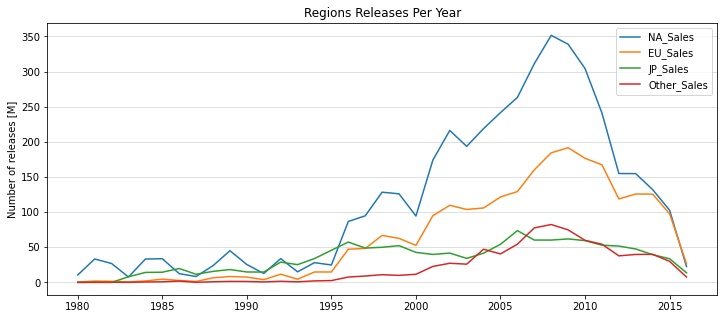

In [14]:
# plot_2 - region releases per year
# list of dataframe columns
columns = list(df)

plt.figure(figsize=(12,5))

# iterate over columns by index
for i in columns[6:10]:
    plt.plot(df.groupby('Year').sum()[i])

plt.title('Regions Releases Per Year')
plt.ylabel('Number of releases [M]')
plt.grid(axis='y', alpha=.5)
plt.legend(columns[6:10])

plt.show()

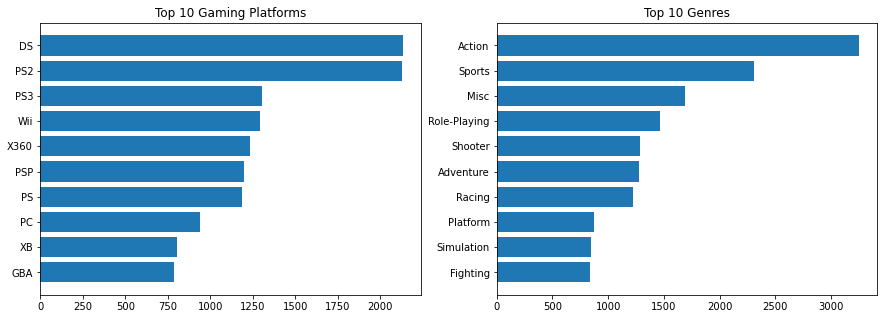

In [15]:
# plot_3 - top 10's
plt.figure(figsize=(15,5))
# space between charts
plt.tight_layout(pad=6)

# subplot_1 - top 10 gaming platforms
x = df['Platform'].value_counts(ascending=False).head(10)
y = x.index

plt.subplot(1, 2, 1)
plt.barh(y, x, align='center', tick_label=y)
plt.gca().invert_yaxis()
plt.title('Top 10 Gaming Platforms')

# subplot_2 - top 10 genres
x = df['Genre'].value_counts(ascending=False).head(10)
y = x.index

plt.subplot(1, 2, 2)
plt.barh(y, x, align='center', tick_label=y)
plt.gca().invert_yaxis()
plt.title('Top 10 Genres')

plt.show()

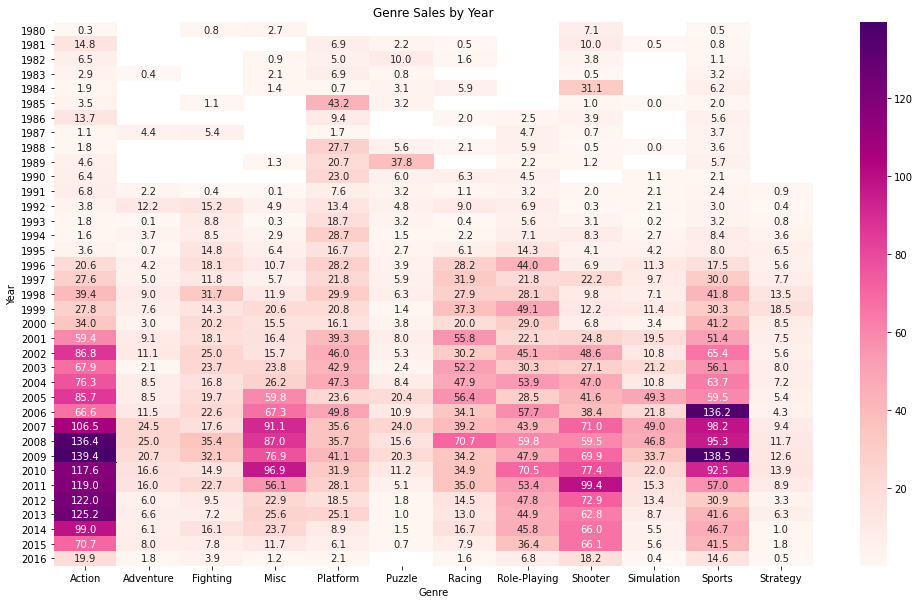

In [16]:
# pivot table
pt = pd.pivot_table(df, index='Year', columns='Genre', values='Global_Sales', aggfunc='sum')
# module for heatmaps
import seaborn as sns

# plot_4 - heatmap of global sales: year vs. genre
plt.figure(figsize=(17,10)) 
ax = sns.heatmap(pt, cmap='RdPu', annot=True, fmt='.1f', cbar=True)
plt.title('Genre Sales by Year')

plt.show()

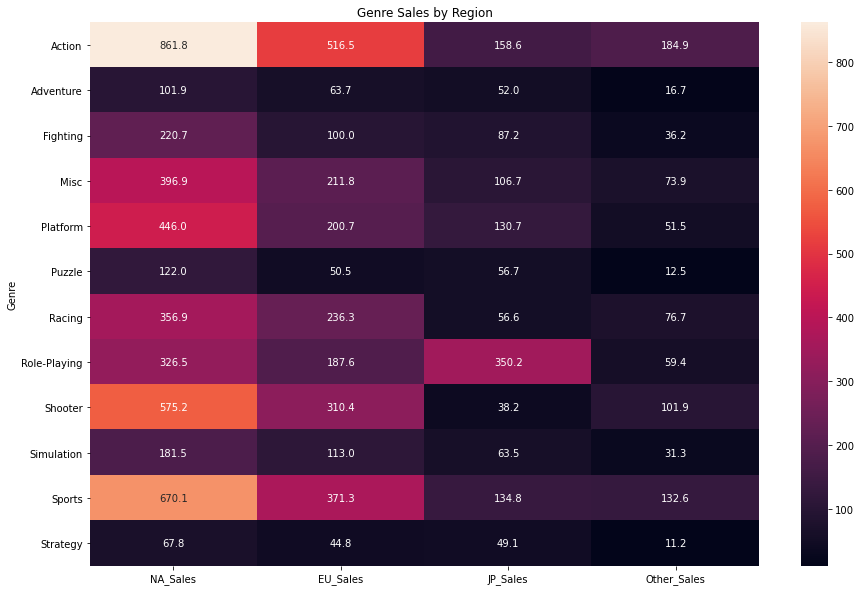

In [17]:
# list of selected columns
column_list = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
# datframe for heatmap
tb = column_list.groupby(by=['Genre']).sum()

# plot_5 - heatmap of genre popularity: region vs. genre
plt.figure(figsize=(15,10))
ax = sns.heatmap(tb, annot=True, fmt='.1f', cbar=True)
plt.title('Genre Sales by Region')

plt.show()

### 4. Predicting Global Sales Based on Europe Sales with Linear Regression

Inspired by another notebook found on the Internet, we'll perform a prediction of global sales based on sales from Europe. We'll try the basic linear regression approach to describe possible relationships between variables.

In [18]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [19]:
# extracting data
X = df['EU_Sales'].values
y = df['Global_Sales'].values

In [20]:
from sklearn.model_selection import train_test_split
# train test split and split the dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [21]:
# reshaping the data into long 2D arrays with 1 column and as many rows as necessary
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [22]:
reg.fit(X_train, y_train)

LinearRegression()

In [23]:
# coefficient R^2
print(reg.score(X_test, y_test))
# coefficient b0
print(reg.intercept_)
# coefficient b1
print(reg.coef_)

0.7781965414143883
[0.12498864]
[[2.82599347]]


In [24]:
# predicted sales
y_pred = reg.predict(X_test)
y_pred

array([[0.20976845],
       [0.12498864],
       [0.12498864],
       ...,
       [0.12498864],
       [0.20976845],
       [0.15324858]])

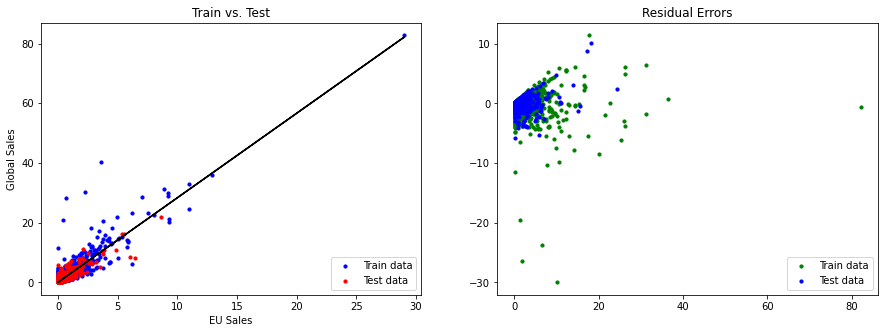

In [25]:
# plot_6 - visualizing linear regression results
plt.figure(figsize=(15,5))

# subplot_1 - training set vs.testing set
plt.subplot(1, 2, 1)
# plotting training data
plt.scatter(X_train, y_train, color='b', s=10, label='Train data')
# plotting testing data
plt.scatter(X_test, y_test, color='r', s=10, label='Test data')
# plotting trend line
plt.plot(X_train, reg.predict(X_train), color='black')
plt.legend(loc='lower right')
plt.xlabel('EU Sales')
plt.ylabel('Global Sales')
plt.title('Train vs. Test')

# subplot_2 - residuals between training and testing data
plt.subplot(1, 2, 2)
# plotting residual errors in training data
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, color='g', s=10, label='Train data')
# plotting residual errors in test data
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, color='b', s=10, label='Test data')
plt.legend(loc='lower right')
plt.title('Residual Errors')

plt.show()

In [26]:
# training set score
print(reg.score(X_train, y_train))
# test set score - coefficient R^2
print(reg.score(X_test, y_test))

0.8200886324796499
0.7781965414143883


In [27]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred)
rmse

0.288914860452914

We performed linear reggression for predicting global sales based on sales from Europe. The trend line seems to be properly positioned within both the training and testing data. As the training set score is close to 1, this indicates that the model is quite accurate. The RMSE suggests the model is well performed. We can also pull out conclusion that European market has a big overall effect on global market.

### 5. Conclusions

This project mainly uses the video game sales dataset to analyze the sales of the global video game industry from 1980 to 2016. The idea of this analysis is to prepare and clean dataset first and then visualize data with Python libraries.<br/>
First charts display overall global sales and in four main regions. Heatmaps are great for visualizing sale data, due to its tabular feature and color scale. We plotted simple bar charts with top platforms and top video game genres.<br/>
Finally, a prediction of global sales was performed based on Europe sales in this time range.